# Predicción de Utilidades de Películas

##  a. Carga de los datos

In [19]:
import pandas as pd
import numpy as np
from scipy.sparse import csr_matrix
from scipy.io import mmread
import matplotlib.pylab as plt
%matplotlib inline

data_dir = "../movies-preproc/ngrams-deprels-fp1-origin.runtime.budget.numscreen.ratings.seasons.stars/"
# data_dir = "../movies-preproc/ngrams-deprels-origin.runtime.budget.numscreen.ratings.seasons/"

# Loading Training data
X = csr_matrix(mmread(data_dir + 'train.x.mm'))
y = np.loadtxt(data_dir + 'train.y.dat')

# Loading Test data
X_test = csr_matrix( mmread(data_dir + 'test.x.mm'))
y_test = np.loadtxt(data_dir + 'test.y.dat')

La ventaja de trabajar con formatos especiales para matrices dispersas (sparse matrices) y no con una librería de matrices densas es la optimización en el uso de la memoria. Si cargáramos una matriz dispersa en una estructura convencional, tendríamos una matriz densa llena de ceros ocupando el espacio de un integer . De este modo, dada la naturaleza del conjunto de datos a cargar, se decide trabajar con la librería para matrices sparse de scipy.

## b. Contrucción de un modelo lineal

Dado el objetivo de crear un modelo lineal que poseea un coeficiente de determinación de más de 0.75, utilizando el conjunto de pruebas, se creó un modelo utilizando regresión lineal ordinaria para así establecer una base comparativa. Posteriormente, se crearon tres modelos adicionales utilizando 3 métodos distintos de regularización: Ridge, Lasso y ElasticNet. A pesar de que este último no se revisó en clases, de todas formas se probó con él, dado que es el método que utilizan los autores del paper *Joshi, M., Das, D., Gimpel, K., Smith, N. A. (2010). Movie reviews and revenues: An experiment in
text regression. In the 2010 Annual Conference of the North American Chapter of the Association for
Computational Linguistics (pp. 293-296). Association for Computational Linguistics*.

### b.1. Least Squares Regression

In [3]:
import sklearn.linear_model as lm
model = lm.LinearRegression(fit_intercept = False)
model.fit(X, y)
print "Least Squares Regression score: {}".format(model.score(X_test, y_test)) 

Least Squares Regression score: 0.59031488104


* ** Least Squares Regression score: 0.59031488104 **

### b.2 Ridge Regression

En este caso, el coeficiente de regularización $\lambda$ se varió entre 100 valores distintos pertenecientes al rango $[10^{-2}, 10^{4}]$.

Best lambda Ridge Regression: 613.590727341, score: 0.593205206685


(0.01, 10000.0, 0.5752126174326162, 0.59320520668539412)

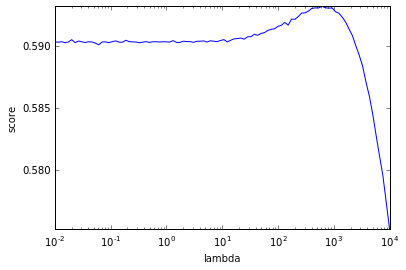

In [12]:
test_R2 = []
lambdas = np.logspace(-2, 4, num=100)
ridge_model = lm.Ridge(fit_intercept=False)

for l in lambdas:    
    ridge_model.set_params(alpha=l)
    ridge_model.fit(X, y)
    test_R2.append(ridge_model.score(X_test, y_test))

i_best_lambda = np.argmax(test_R2)   
print "Best lambda Ridge Regression: {}, score: {}".format(lambdas[i_best_lambda], test_R2[i_best_lambda])

ax = plt.gca()
ax.plot(lambdas, test_R2)
ax.set_xscale('log')
plt.xlabel('lambda')
plt.ylabel('score')
plt.axis('tight')

Como puede verse en la figura de arriba, el score o coeficiente de determinación se mantiene prácticamente invariable cuando $\lambda$ es menor a 10. Posteriormente y a partir de $\lambda=100$ el score comienza a aumentar para llegar a un máximo de $0.5933$ (apenas superior al modelo de regresión lineal ordinaria), con un $\lambda=606.9215$. Con valores más grandes de $\lambda$, el score disminuye drásticamente.

### b.3 Lasso Regression

En este caso, el coeficiente de regularización $\lambda$ se varió entre 100 valores distintos y pertenecientes al rango $[1000, 5000]$. Pruebas preliminares determinaron que valores muy pequeños de $\lambda$ resultaban en problemas de convergencia del método, incluso arrojando valores negativos para el score. A partir de un $\lambda=1000$ se comenzaron a ver valores relevantes para este último.

Best lambda Lasso Regression: 1848.48484848, score: 0.546971190802


(1000.0, 5000.0, 0.53277933587595094, 0.54697119080152357)

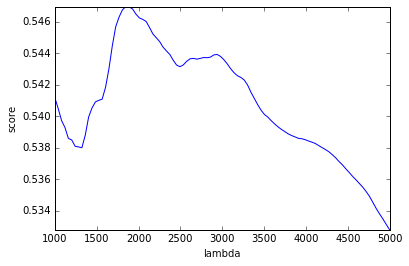

In [13]:
test_R2 = []
lambdas = np.linspace(1000, 5000, num=100)
lasso_model = lm.Lasso(fit_intercept=False)

for l in lambdas:    
    lasso_model.set_params(alpha=l)
    lasso_model.fit(X, y)
    test_R2.append(lasso_model.score(X_test, y_test))

i_best_lambda = np.argmax(test_R2)  
print "Best lambda Lasso Regression: {}, score: {}".format(lambdas[i_best_lambda], test_R2[i_best_lambda])

ax = plt.gca()
ax.plot(lambdas, test_R2)
plt.xlabel('lambda')
plt.ylabel('score')
plt.axis('tight')

Con Lasso, el score máximo es de $0.5470$ con un $\lambda=1848.4848$. Este resultado es menor al obtenido con regresión lineal ordinaria y regularizando con Ridge. 

### b.4 ElasticNet Regression

No se entrará en detalles acerca de los fundamentos de este método, el cual no se revisa en clases, pero la [documentación de Scikit Learn](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.ElasticNet.html#sklearn.linear_model.ElasticNet) ofrece pequeña visión que resulta útil para entenderlo. 

Básicamente, este método utiliza una combinación de las normas L1 (implementado en Lasso) y L2 (implementado en Ridge) para realizar el proceso de regularización. En ese sentido, dos coeficientes son relevantes: alpha y l1_ratio. De acuerdo a la [documentación de Scikit Learn](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.ElasticNet.html#sklearn.linear_model.ElasticNet):

* **alpha:** flotante. Constante que multiplica los términos penalizadores. Valor por defecto igual a 1. alpha = 0 es equivalente a una regresión de mínimos cuadrados. 

* **l1_ratio:** flotante. Parámetro de mezcla de ElasticNet, con 0 <= l1_ratio <= 1. Para l1_ratio = 0 la regularización corresponde a una penalización L2. Para l1_ratio = 1 corresponde a una penalización L1. Para 0 < l1_ratio < 1, la regularización es una combinación de L1 y L2.


Para el valor de l1_ratio se consideró un valor igual a $0.1, 0.2, \ldots, 0.9$. Para alfa se consideraron 25 valores distintos logespaciados dentro del rango $[10^{-2}, 10^2]$.

In [14]:
test_R2 = []
l1_ratios = np.linspace(0.1, 0.9, 9)
alphas = np.logspace(-2, 2, 25)

enet_model = lm.ElasticNet(fit_intercept=False)

for l1r in l1_ratios:
    enet_model.set_params(l1_ratio=l1r)    
    for alpha in alphas:
        enet_model.set_params(alpha=alpha)
        enet_model.fit(X, y)
        test_R2.append((l1r, alpha, enet_model.score(X_test, y_test)))

from operator import itemgetter
best_parameters = max(test_R2, key=itemgetter(2))
print "Best parameters ElasticNet Regression:" 
print "l1_ratio: {}, lambda: {}, score: {}".format(best_parameters[0], best_parameters[1], best_parameters[2])

Best parameters ElasticNet Regression:
l1_ratio: 0.6, lambda: 0.215443469003, score: 0.607251854068


Luego de una larga ejecución del código anterior, se obtuvo un score máximo igual a $0.6073$ (superior al de regresión lineal ordinaria), utilizando un alfa igual a $0.2154$ y un l1_ratio igual a $0.6$.

**Finalmente, con ningún modelo de regularización se logró la meta de los 0.75 para el score o coeficiente de correlación.**